## Visualize the Environment Model

Evaluate and visualize the performance of the environment model by seeing it visualize future states while a A2C agent plays the game.

In [1]:
import numpy as np
import tensorflow as tf
from env_model_minigrid import make_env, create_env_model
from common.multiprocessing_env import SubprocVecEnv
from common.minigrid_util import num_pixels, mode_rewards, pix_to_target, rewards_to_target
from a2c import get_actor_critic, CnnPolicy
from i2a import convert_target_to_real
import gym
import gym_minigrid
import common.minigrid_util

In [2]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
import time
%matplotlib inline
%load_ext autoreload
%autoreload 2

Next create the environments we will use.

In [3]:
env_name = "MiniGrid-Blocks-6x6-v0"
nenvs = 16
nsteps = 5
envs = [make_env(env_name) for i in range(nenvs)]
envs = SubprocVecEnv(envs)

ob_space = envs.observation_space.shape
ac_space = envs.action_space
num_actions = envs.action_space.n

Finally, go ahead and test the environment model in minigrid. This will use the A2C agent to play the game and the environment model to predict future states and rewards. This will visualize the imagined and real rewards and game states from the environment model. 

In [4]:
#Make minigrid env...
env = gym_minigrid.wrappers.ImgObsWrapper(gym.make(env_name))

done = False
states = env.reset()
num_actions = ac_space.n
nw, nh, nc = ob_space
print('observation space', ob_space)
print('number of actions', num_actions)
steps = 0

observation space (6, 6, 3)
number of actions 5


In [5]:
tf.reset_default_graph()
n_steps = 20
pred_states = np.zeros((n_steps, nw, nh, nc))
act_states = np.zeros((n_steps, nw, nh, nc))
pred_rewards = np.zeros(n_steps)
act_rewards = np.zeros(n_steps)

with tf.Session() as sess:
    # Load the actor
    with tf.variable_scope('actor'):
        actor_critic = get_actor_critic(sess, nenvs, nsteps, ob_space,
                ac_space, CnnPolicy, should_summary=False)
    actor_critic.load('weights/a2c_100000.ckpt')
    
    # Load the critic
    with tf.variable_scope('env_model'): 
        env_model = create_env_model(ob_space, num_actions, num_pixels,
                len(mode_rewards['regular']), should_summary=False)

    save_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='env_model')
    loader = tf.train.Saver(var_list=save_vars)
    loader.restore(sess, 'weights/env_model.ckpt')
    
    while not done and steps < n_steps:
        steps += 1
        actions, _, _ = actor_critic.act(np.expand_dims(states, axis=0))

        onehot_actions = np.zeros((1, num_actions, nw, nh))
        onehot_actions[range(1), actions] = 1
        # Change so actions are the 'depth of the image' as tf expects
        onehot_actions = onehot_actions.transpose(0, 2, 3, 1)

        s, r = sess.run([env_model.imag_state, 
                                        env_model.imag_reward], 
                                       feed_dict={
                env_model.input_states: np.expand_dims(states, axis=0),
                env_model.input_actions: onehot_actions
            })
        
        s, r = convert_target_to_real(1, nw, nh, nc, s, r)
        
        states, reward, done, _ = env.step(actions[0])

        pred_states[steps,:,:,:] = s[0]
        act_states[steps,:,:,:] = states
        pred_rewards[steps] = r
        act_rewards[steps] = reward

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
INFO:tensorflow:Restoring parameters from weights/a2c_100000.ckpt
INFO:tensorflow:Restoring parameters from weights/env_model.ckpt


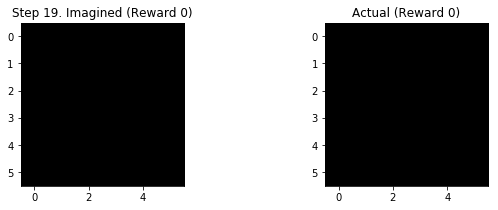

In [9]:
#Visualize...
#for steps in range(n_steps-1,0,-1):
for steps in range(n_steps):
    clear_output(True)
    plt.figure(figsize=(10,3))
    plt.subplot(121)
    plt.title("Step %d. Imagined (Reward %i)" % (steps,pred_rewards[steps]))
    plt.imshow(pred_states[steps,:,:,:]*11./255)
    plt.subplot(122)
        
    plt.title("Actual (Reward %i)" % act_rewards[steps])
    plt.imshow(act_states[steps,:,:,:]*11./255)
    plt.show()
    time.sleep(1)

In [7]:
#Weird thing with environment and reward dynamics... looks like x and y axes are being mixed somehow...